<a href="https://colab.research.google.com/github/vinay-500/pytorch_starter/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# conver MNIST image files to tensor of 4-dim
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.MNIST(root='/cnn_data',
                            train=True,
                            download=True,
                            transform=transform)

In [59]:
test_data = datasets.MNIST(root='/cnn_data',
                            train=False,
                            download=True,
                            transform=transform)

In [60]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [61]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [62]:
train_loader = DataLoader(train_data,
                          batch_size=10,
                          shuffle=True)
test_loader = DataLoader(test_data,
                          batch_size=10,
                          shuffle=True)

In [63]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


In [64]:
for i, (X_train, y_train) in enumerate(train_data):
  break

In [65]:
X_train.shape

torch.Size([1, 28, 28])

In [66]:
x = X_train.view(1, 1, 28, 28)

In [67]:
x = F.relu(conv1(x))


In [68]:
x.shape

torch.Size([1, 6, 26, 26])

In [69]:
# Pass thru the pooling layer

In [70]:
x = F.max_pool2d(x, 2, 2) # kernal 2 and stride 2

In [71]:
x.shape

torch.Size([1, 6, 13, 13])

In [72]:
x = F.relu(conv2(x))


In [73]:
x.shape

torch.Size([1, 16, 11, 11])

In [74]:
x = F.max_pool2d(x, 2, 2) # kernal 2 and stride 2

In [75]:
x.shape # 11/2 = 5.5 but round down because we cant add data (invent data)

torch.Size([1, 16, 5, 5])

In [76]:
((28 - 2) / 2  - 2 ) /2

5.5

In [77]:
class ConvolutionNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5 * 5 * 16 , 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    # second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re view to flatten it out
    X = X.view(-1, 16*5*5) # -ve 1 so that we can vary the batch size

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim =1 )

In [78]:
torch.manual_seed(41)

model = ConvolutionNetwork()
model

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [79]:
# Loss fucntion optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # smaller the lr

In [80]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start out batches at 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum() # how many are crct fromthis batch
    trn_corr += batch_corr# keep track

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)




current_time = time.time()
total_time = current_time - start_time
print(f"Training took: {total_time/60} minutes")

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.02950388565659523
Epoch: 1 Batch: 1200 Loss: 0.01223783753812313
Epoch: 1 Batch: 1800 Loss: 0.0017079260433092713
Epoch: 1 Batch: 2400 Loss: 0.004794587381184101
Epoch: 1 Batch: 3000 Loss: 0.00012589071411639452
Epoch: 1 Batch: 3600 Loss: 0.006774441804736853
Epoch: 1 Batch: 4200 Loss: 0.00024002441205084324
Epoch: 1 Batch: 4800 Loss: 0.011869433335959911
Epoch: 1 Batch: 5400 Loss: 0.0003403539885766804
Epoch: 1 Batch: 6000 Loss: 0.0003896451380569488
Epoch: 2 Batch: 600 Loss: 0.2102451026439666

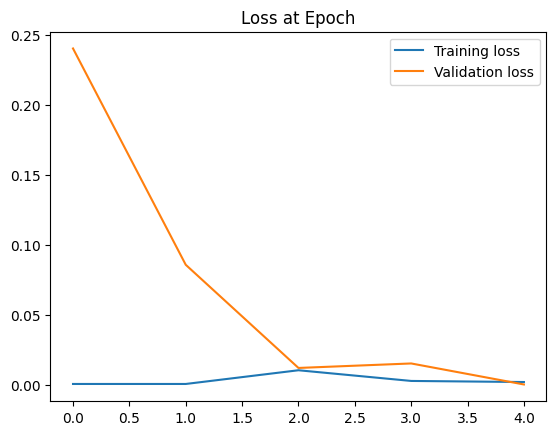

In [81]:
train_losses = [t1.item() for t1 in train_losses]
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Loss at Epoch")
plt.legend()

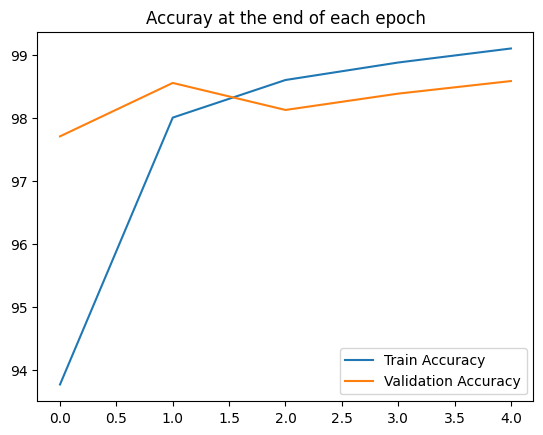

In [82]:
plt.plot([t/600 for t in train_correct], label="Train Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuray at the end of each epoch")
plt.legend()

In [83]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [84]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      correct += (predicted == y_test).sum()

In [85]:
correct

tensor(9859)

In [86]:
test_data[4141] # label at the end

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [87]:
test_data[4141][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [88]:
# reshape

In [89]:
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

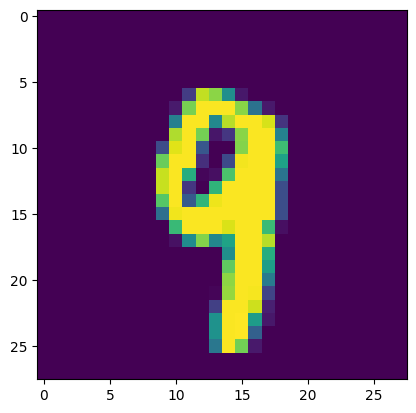

In [90]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [91]:
# Pass impage thru model

In [92]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28))

In [93]:
new_prediction

tensor([[-1.9783e+01, -2.0513e+01, -2.0931e+01, -1.3588e+01, -9.8797e+00,
         -1.4948e+01, -3.3749e+01, -9.2057e+00, -1.4788e+01, -1.5365e-04]])

In [94]:
new_prediction.argmax()

tensor(9)